In [18]:
# # spark libraries
# import pyspark
# from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('hard_drives_smart_5.csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [4]:
import pandas as pd
import numpy as np
import re 


def get_manufacturer(model):
    if model.startswith('ST'):
        return 'Seagate'
    elif model.startswith('Sea'):
        return 'Seagate'
    elif model.startswith('HGST'):
        return 'Hitachi'
    elif model.startswith('Hit'):
        return 'Hitachi'
    elif model.startswith('TOS'):
        return 'Toshiba'
    elif model.startswith('DEL'):
        return 'Dell'
    elif model.startswith('WD'):
        return 'Western Digital'
    elif model.startswith('Sam'):
        return 'Samsung'
    elif model.startswith('SAM'):
        return 'Samsung'
    else:
        return 'Unknown'


def prepare(df):
    
    # Convert capacity column from bytes to terabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000_000),1)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Create a new column for manufacturer
    df['manufacturer'] = df.model.apply(get_manufacturer)
    
    # Rename columns appropriately
    df = df.rename(columns={'capacity_bytes':'capacity_terabytes',
                        'max(failure)':'failure',
                        'max(smart_9_raw)':'drive_age_in_years',
                        'max(smart_5_raw)':'reallocated_sectors_count',
                        'max(smart_187_raw)':'reported_uncorrectable_errors',
                        'max(smart_188_raw)':'command_timeout',
                        'max(smart_197_raw)':'current_pending_sector_count',
                        'max(smart_198_raw)':'uncorrectable_sector_count'})

    # Reorder columns 
    df = df[['serial_number','manufacturer','model','capacity_terabytes',
          'failure','drive_age_in_years','reallocated_sectors_count',
         'reported_uncorrectable_errors','command_timeout',
          'current_pending_sector_count','uncorrectable_sector_count']]
    
    return df


def unique(df):
    '''
    Remove rows that duplicate serial numbers after aggregation.
    '''
    
    # remove rows with 0 copacity_terabytes they were creating duplicate rows for some of the serial numbers
    df = df[df.capacity_terabytes > 0]
    
    # remove rows by index that were creating duplicate serial numbers 
    df = df.drop([68273,50408,37150,154660,162948,50816,156370,31687,20823,75191,132189,4177,78104,103620,141505,95249,26969])
    
    return df


def treat_nulls(df):
    # remove nulls from specific columns by imputing zeroes
    df.reported_uncorrectable_errors = df.reported_uncorrectable_errors.fillna(value=0)
    df.command_timeout = df.command_timeout.fillna(value=0)
    
    # treat remaining nulls by dropping specific rows
    df = df.dropna(axis=0)
    return df

In [5]:
df = prepare(df)

In [6]:
df = unique(df)

In [7]:
df = treat_nulls(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [12]:
import pandas as pd 
import numpy as np 


def remove_manufacturers(df):
    # Remove manufactures with low value counts
    df = df[(df.manufacturer != 'Samsung') & (df.manufacturer != 'Unknown')]
    return df


def early_failure(df,cut_off=1.6):
    '''
    Add column to identify early failures based on the age of the hard drive 

    '''
    df['early_failure'] = np.where((df.drive_age_in_years <= cut_off) & (df.failure == 1), 1, 0)
    return df

def old_or_fail(df,cut_off=1.6):
    '''
    Retain rows for drives that have failed or are older than the cut off age
    '''
    df = df[(df.failure==1)|(df.drive_age_in_years > cut_off)]

    return df

def make_binary_values(df):
    df.reallocated_sectors_count = np.where(df.reallocated_sectors_count > 0, '1','0').astype(bool)
    df.reported_uncorrectable_errors = np.where(df.reported_uncorrectable_errors > 0, '1', '0').astype(bool)
    df.command_timeout = np.where(df.command_timeout > 0, '1', '0').astype(bool)
    df.current_pending_sector_count = np.where(df.current_pending_sector_count > 0, '1', '0').astype(bool)
    df.uncorrectable_sector_count = np.where(df.uncorrectable_sector_count > 0, '1', '0').astype(bool)
    return df


def get_quartile(df,Q1=1.6,Q2=2.6,Q3=4):
    '''
    Add colulmn to identify which quartile drive falls in based on the age of the hard drive
    '''
    df['quartile']= 1
    df['quartile'][df.drive_age_in_years<Q1] = 'Q1'
    df['quartile'][(df.drive_age_in_years>=Q1) & (df.drive_age_in_years<Q2)] = 'Q2'
    df['quartile'][(df.drive_age_in_years>=Q2) & (df.drive_age_in_years<Q3)] = 'Q3'
    df['quartile'][(df.drive_age_in_years>=Q3)] = 'Q4'
    return df

In [13]:
df = remove_manufacturers(df)

In [19]:
df = early_failure(df)

In [16]:
df = old_or_fail(df)

In [20]:
df = make_binary_values(df)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    121900 non-null object
manufacturer                     121900 non-null object
model                            121900 non-null object
capacity_terabytes               121900 non-null float64
failure                          121900 non-null int64
drive_age_in_years               121900 non-null float64
reallocated_sectors_count        121900 non-null bool
reported_uncorrectable_errors    121900 non-null bool
command_timeout                  121900 non-null bool
current_pending_sector_count     121900 non-null bool
uncorrectable_sector_count       121900 non-null bool
early_failure                    121900 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 8.0+ MB


In [24]:
df.groupby('failure').sum().iloc[:,2:-1]

,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
failure,,,,,
0,3174.0,1534.0,3308.0,1515.0,1282.0
1,1909.0,2079.0,559.0,2489.0,2190.0


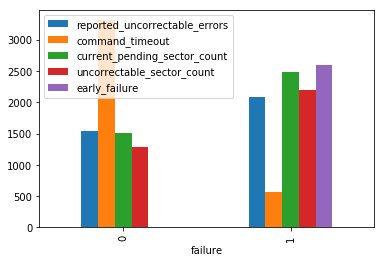

In [25]:
df.groupby('failure').sum().iloc[:,3:].plot.bar()
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    121900 non-null object
manufacturer                     121900 non-null object
model                            121900 non-null object
capacity_terabytes               121900 non-null float64
failure                          121900 non-null int64
drive_age_in_years               121900 non-null float64
reallocated_sectors_count        121900 non-null bool
reported_uncorrectable_errors    121900 non-null bool
command_timeout                  121900 non-null bool
current_pending_sector_count     121900 non-null bool
uncorrectable_sector_count       121900 non-null bool
early_failure                    121900 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 8.0+ MB


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def split_my_data(df):
    # define target and features
    X = df.drop(columns = ['serial_number', 'early_failure', 'failure', 'drive_age_in_years'])
    y = df[['early_failure']]

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, random_state = 123, stratify=df.early_failure)
    return X_train, X_test, y_train, y_test

def encode_hot(train, test, col_name):
    encoded_values = sorted(list(train[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    # and drop original column
    train_encoded = pd.DataFrame(data=train_ohe, columns=encoded_values, index=train.index)
    train = train.join(train_encoded)
    train = train.drop(columns = col_name)

    test_encoded = pd.DataFrame(data=test_ohe, columns=encoded_values, index=test.index)
    test = test.join(test_encoded)
    test = test.drop(columns = col_name)

    return train, test

In [40]:
X_train, X_test, y_train, y_test = split_my_data(df)

In [41]:
X_train.columns

Index(['manufacturer', 'model', 'capacity_terabytes',
       'reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

In [43]:
X_train.drop(columns='manufacturer', inplace=True)
X_test.drop(columns='manufacturer', inplace=True)
X_train.drop(columns='model', inplace=True)
X_test.drop(columns='model', inplace=True)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [54]:
def logit_model(X_train, y_train):
    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)

    print(pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(logit.coef_))], axis = 1))
    print()
    print(y_pred_proba)
    print()
    print(confusion_matrix(y_train, y_pred))
    print()    
    print(classification_report(y_train, y_pred))

In [55]:
logit_model(X_train, y_train)

                               0         0
0             capacity_terabytes  0.141913
1      reallocated_sectors_count  1.690532
2  reported_uncorrectable_errors  1.665785
3                command_timeout  1.048962
4   current_pending_sector_count  3.553712
5     uncorrectable_sector_count -1.070643

[[0.66374181 0.33625819]
 [0.77689584 0.22310416]
 [0.52806058 0.47193942]
 ...
 [0.77689584 0.22310416]
 [0.77689584 0.22310416]
 [0.77689584 0.22310416]]

[[89526  5916]
 [  754  1324]]

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     95442
           1       0.18      0.64      0.28      2078

    accuracy                           0.93     97520
   macro avg       0.59      0.79      0.62     97520
weighted avg       0.97      0.93      0.95     97520



In [189]:
from sklearn.model_selection import GridSearchCV

def grid_logit_model(X_train, y_train):
    # create object
    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)
    # set a range of hyperparameters
    grid_values = {'C':[0.001,.009,0.01,.09,1,5,10,25]}
    
    # grid search returns recall values
    grid = GridSearchCV(logit, grid_values, cv=3, scoring='recall')
    grid.fit(X_train, y_train)    
    
    # retrieve results
    results = grid.cv_results_
    test_scores = results['mean_test_score']
    params = results['params']
    
    # zip results together for dataframe
    for p, s in zip(params, test_scores):
        p['score'] = s    
        
    return pd.DataFrame(params).sort_values(by='score')

In [190]:
grid_logit_model(X_train, y_train)

,C,score
0,0.001,0.627054
1,0.009,0.637156
2,0.010,0.637156
3,0.090,0.637156
4,1.000,0.637156
5,5.000,0.637156
6,10.000,0.637156
7,25.000,0.637156


## statistical significance 

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 168960
Data columns (total 12 columns):
serial_number                    121900 non-null object
manufacturer                     121900 non-null object
model                            121900 non-null object
capacity_terabytes               121900 non-null float64
failure                          121900 non-null int64
drive_age_in_years               121900 non-null float64
reallocated_sectors_count        121900 non-null bool
reported_uncorrectable_errors    121900 non-null bool
command_timeout                  121900 non-null bool
current_pending_sector_count     121900 non-null bool
uncorrectable_sector_count       121900 non-null bool
early_failure                    121900 non-null int64
dtypes: bool(5), float64(2), int64(2), object(3)
memory usage: 8.0+ MB


In [60]:
df.model.value_counts()

ST4000DM000                35738
HGST HMS5C4040BLE640       15844
ST12000NM0007              14881
ST8000NM0055               14499
ST8000DM002                10041
                           ...  
TOSHIBA HDWF180                1
Hitachi HDS5C3030BLE630        1
WDC WD2500BEVT                 1
WDC WD3200BEKT                 1
ST31500341AS                   1
Name: model, Length: 90, dtype: int64

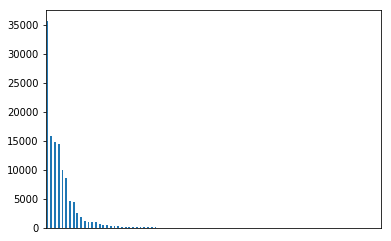

In [71]:
df.model.value_counts().plot.bar()
plt.xticks([])
plt.show()

In [72]:
from scipy import stats

In [80]:
df.model.value_counts() [df.model.value_counts() > 1000]

ST4000DM000                35738
HGST HMS5C4040BLE640       15844
ST12000NM0007              14881
ST8000NM0055               14499
ST8000DM002                10041
HGST HMS5C4040ALE640        8617
Hitachi HDS5C3030ALA630     4561
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1911
ST10000NM0086               1204
WDC WD30EFRX                1083
HGST HUH728080ALE600        1046
Name: model, dtype: int64

In [192]:
observed = pd.crosstab(df.model == 'HGST HDS5C4040ALE630', df.early_failure)
observed

early_failure,0,1
model,,
False,119210,2596
True,92,2


In [92]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[119210   2596]
 [    92      2]]
---
Expected

[[1.19210003e+05 2.59599662e+03]
 [9.19966202e+01 2.00337982e+00]]
---

chi^2 = 0.1259
p     = 0.7227


### H0: model is independent of early failure rate

In [171]:
stats_list = []

for model in df.model.unique():
    observed = pd.crosstab(df.model == model, df.early_failure)
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    
    chi2 = round(chi2,4)
    p = round(p,4)
    signif = p < 0.05
    
    stats_list.append([model, chi2, p, signif])

In [172]:
df_stat = pd.DataFrame(stats_list, columns=['model','chi2', 'p', 'signif'])
df_stat

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,57.7005,0.0000,True
1,ST4000DM000,0.1266,0.7220,False
2,Hitachi HDS5C3030ALA630,102.1253,0.0000,True
3,ST8000DM002,9.3981,0.0022,True
4,HGST HMS5C4040BLE640,150.7252,0.0000,True
...,...,...,...,...
85,ST3500320AS,10.9857,0.0009,True
86,WDC WD3200AAKS,10.9857,0.0009,True
87,Hitachi HDS724040ALE640,3.0388,0.0813,False
88,WDC WD2500AAJB,10.9857,0.0009,True


In [174]:
df_stat [df_stat.signif == True]

,model,chi2,p,signif
0,Hitachi HDS5C4040ALE630,57.7005,0.0000,True
2,Hitachi HDS5C3030ALA630,102.1253,0.0000,True
3,ST8000DM002,9.3981,0.0022,True
4,HGST HMS5C4040BLE640,150.7252,0.0000,True
6,ST6000DX000,18.8957,0.0000,True
7,HGST HMS5C4040ALE640,153.5531,0.0000,True
10,Hitachi HDS722020ALA330,100.7634,0.0000,True
11,WDC WD10EADS,5.4562,0.0195,True
12,Hitachi HDS723030ALA640,20.9386,0.0000,True
15,HGST HUH728080ALE600,5.3853,0.0203,True


In [176]:
len(df_stat [df_stat.signif == True])

51

In [177]:
stat_sig_models = list(df_stat [df_stat.signif == True].model)

In [178]:
df.model [df.model.isin(stat_sig_models)].value_counts()

HGST HMS5C4040BLE640       15844
ST12000NM0007              14881
ST8000NM0055               14499
ST8000DM002                10041
HGST HMS5C4040ALE640        8617
Hitachi HDS5C3030ALA630     4561
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1911
ST10000NM0086               1204
HGST HUH728080ALE600        1046
Hitachi HDS723030ALA640     1000
TOSHIBA MQ01ABF050           545
WDC WD10EADS                 295
ST31500541AS                 264
TOSHIBA MQ01ABF050M          192
ST4000DM001                   34
ST4000DM005                   31
WDC WD20EFRX                  29
ST500LM030                    28
HGST HUH721212ALN604          25
TOSHIBA MG07ACA14TA           11
WDC WD3200BEKX                11
ST8000DM005                    7
ST12000NM0117                  5
ST4000DX002                    5
ST8000DM004                    4
HGST HUH721212ALE600           4
WDC WD10EARX                   2
WDC WD5003ABYX                 2
WDC WD1600